In [326]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17

import seaborn as sns
import re
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)

In [327]:
## 1. Data
### 1.1 Load Data
data = pd.read_csv('../app/data/total.csv')

    The following table is a view of the raw data from the scrape. I'll build the target by reducing the pay column to floating point values; this will require text cleaning which will also be conducted for the rest of the table. Location will be split into new columns for City and State while and because Indeed's search results show dates relative to the date the query was made I'll need to use PostDate and ExtractDate build a DatePosted column. It is important to note that JobUrl and date-related columns will not be converted into features for the logistic regression, instead they will be reattached to the data at the end in order to provide additional information and insights through the EC2 application. The only rows that'l  be using for modelling are JobTitle, Company, Summary, Requirements, and Description.

In [328]:
### 1.2 EDA: Initial Data Inspection
#### 1.2.1 Examine Dataset
data.head()

,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jType,salfromsection,summary,title,url
0,Online Technical Services,"Job descriptionData Scientist, MarketingSAN DI...",NaN,2022-04-13,['Full-time'],Remote,PostedJust posted,3.7,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Master's (Preferred)Python: 1 year (Preferred)...,NaN,"$145,000 - $150,000 a year","$145,000 - $150,000 a year - Full-time","$145,000 - $150,000 a year",Identify relevant data sources and data sets t...,Data Scientist - Marketing,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,West CAP,HUMAN was founded in 2012 in a Brooklyn sci-fi...,Estimated $114K – $144K a year,2022-04-13,NaN,"Remote in New York, NY+2 locations",PostedJust posted,3.5,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$114K to $14...",NaN,Full-time,NaN,You’ve worked as a data scientist solving larg...,"Data Scientist, BotGuard",https://www.indeed.com/rc/clk?jk=58cdde046f643...
2,Maya Ai inc.,Our Maya team is expanding and we are looking ...,NaN,2022-04-13,"['Full-time', 'Part-time']",Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Python: 1 year (Preferred)SQL: 1 year (Preferred),NaN,"$77,766 - $183,411 a year","$77,766 - $183,411 a year - Full-time, Part-time","$77,766 - $183,411 a year",Our Analyst will be dealing with data coming i...,Data Scientist,https://www.indeed.com/company/Maya-Ai-inc./jo...
3,"EMERGETECH, INC",Description:Job CategoryData ScienceAbout Emer...,Estimated $94.7K – $120K a year,2022-04-13,NaN,Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$94.7K to $1...",NaN,NaN,NaN,Design and create the data sources that ”citiz...,Data Scientist,https://www.indeed.com/rc/clk?jk=95fb128bb025f...
4,Recurrent,What's the opportunity?Recurrent is on a missi...,Estimated $119K – $151K a year,2022-04-13,NaN,"Remote in Seattle, WA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$119K to $15...",NaN,NaN,NaN,Experienced - you have 2+ years of experience ...,Data Scientist,https://www.indeed.com/rc/clk?jk=e9ce610b72deb...


In [329]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           1515 non-null   object 
 1   description       1515 non-null   object 
 2   estimated_salary  686 non-null    object 
 3   extractDate       1515 non-null   object 
 4   job_type_items    361 non-null    object 
 5   location          1515 non-null   object 
 6   postDate          1515 non-null   object 
 7   rating            1035 non-null   float64
 8   raw_desc_soup     1515 non-null   object 
 9   requirements      187 non-null    object 
 10  sal_guide_items   753 non-null    object 
 11  salary            447 non-null    object 
 12  salary_and_jType  1025 non-null   object 
 13  salfromsection    446 non-null    object 
 14  summary           1515 non-null   object 
 15  title             1515 non-null   object 
 16  url               1515 non-null   object 


In [330]:
data.shape

(1515, 17)

In [331]:
#### 1.2.2 Examine & Modify Dataset Columns
data.columns = map(str.lower, data.columns)
data.columns
#TODO rename more
data = data.rename({'title': 'job_title'}, axis=1)

In [332]:
##### 1.2.2.1 Missing Values?
data.isnull().sum()

company                0
description            0
estimated_salary     829
extractdate            0
job_type_items      1154
location               0
postdate               0
rating               480
raw_desc_soup          0
requirements        1328
sal_guide_items      762
salary              1068
salary_and_jtype     490
salfromsection      1069
summary                0
job_title              0
url                    0
dtype: int64

In [333]:
data[data.isnull().any(axis=1)]
# every column has nulls! This is partially due to salary being estimated, stated by the hiring company, or not being provided at all. Every observation includes one of these types of salary.

,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jtype,salfromsection,summary,job_title,url
0,Online Technical Services,"Job descriptionData Scientist, MarketingSAN DI...",NaN,2022-04-13,['Full-time'],Remote,PostedJust posted,3.7,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Master's (Preferred)Python: 1 year (Preferred)...,NaN,"$145,000 - $150,000 a year","$145,000 - $150,000 a year - Full-time","$145,000 - $150,000 a year",Identify relevant data sources and data sets t...,Data Scientist - Marketing,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,West CAP,HUMAN was founded in 2012 in a Brooklyn sci-fi...,Estimated $114K – $144K a year,2022-04-13,NaN,"Remote in New York, NY+2 locations",PostedJust posted,3.5,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$114K to $14...",NaN,Full-time,NaN,You’ve worked as a data scientist solving larg...,"Data Scientist, BotGuard",https://www.indeed.com/rc/clk?jk=58cdde046f643...
2,Maya Ai inc.,Our Maya team is expanding and we are looking ...,NaN,2022-04-13,"['Full-time', 'Part-time']",Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Python: 1 year (Preferred)SQL: 1 year (Preferred),NaN,"$77,766 - $183,411 a year","$77,766 - $183,411 a year - Full-time, Part-time","$77,766 - $183,411 a year",Our Analyst will be dealing with data coming i...,Data Scientist,https://www.indeed.com/company/Maya-Ai-inc./jo...
3,"EMERGETECH, INC",Description:Job CategoryData ScienceAbout Emer...,Estimated $94.7K – $120K a year,2022-04-13,NaN,Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$94.7K to $1...",NaN,NaN,NaN,Design and create the data sources that ”citiz...,Data Scientist,https://www.indeed.com/rc/clk?jk=95fb128bb025f...
4,Recurrent,What's the opportunity?Recurrent is on a missi...,Estimated $119K – $151K a year,2022-04-13,NaN,"Remote in Seattle, WA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$119K to $15...",NaN,NaN,NaN,Experienced - you have 2+ years of experience ...,Data Scientist,https://www.indeed.com/rc/clk?jk=e9ce610b72deb...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510,Lucid Technologies Inc,Job Title: Information Security Data Scientist...,Estimated $95.4K - $121K a year,2022-04-20,NaN,"Remote in Dallas, TX",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$95.4K - $12...",NaN,NaN,NaN,Participate as a key member of the analytics a...,Information Security Data Scientist (Remote),https://www.indeed.com/rc/clk?jk=6202e64a38d75...
1511,Windstream Communications,We are looking for a data scientist to help us...,NaN,2022-04-20,NaN,Remote,PostedJust posted,3.2,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,Full-time,NaN,You will also be responsible for acquisition o...,Senior Data Scientist,https://www.indeed.com/rc/clk?jk=5362358221574...
1512,Edmunds.com,At Edmunds we’re driven to make car buying eas...,Estimated $47.5K - $60.1K a year,2022-04-20,NaN,"Remote in Santa Monica, CA 90404",PostedJust posted,3.4,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$47.5K to $6...",NaN,Full-time,NaN,The senior analyst/data scientist will serve a...,Senior Analyst/Data Scientist,https://www.indeed.com/rc/clk?jk=9dcaee4b15174...
1513,One Concern,About One Concern One Concern brings disaster ...,Estimated $118K - $150K a year,2022-04-20,NaN,Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$118K - $150...",NaN,Full-time,NaN,Collaborate with an interdisciplinary team of ...,"Senior Data Scientist, Wind Resilience",https://www.inde

In [334]:
#  Value Counts
data.nunique()

company               97
description          119
estimated_salary      89
extractdate            6
job_type_items         4
location              83
postdate               4
rating                22
raw_desc_soup       1395
requirements          10
sal_guide_items       87
salary                34
salary_and_jtype      38
salfromsection        34
summary              165
job_title             89
url                  302
dtype: int64

In [335]:
### 1.3 EDA: Initial Statistics
data.describe()

,rating
count,1035.000000
mean,3.691594
std,0.562992
min,1.500000
25%,3.500000
50%,3.700000
75%,4.100000
max,5.000000


In [336]:
null = sum(data.salary.isnull())
nnull = sum(data.salary.notnull())
print(data.isnull().sum())
print('')
print(f'The data contains {data.shape[0]} rows of individual job postings with values for {data.shape[1]} columns based on\n different sections of each post\'s web page.')
print('')
print(f'- Out of {len(data)} job postings {nnull} or {round(nnull/len(data)*100,2)}% include some sort of salary information,\n- The remaining {null} rowws, or {round(null/len(data)*100,2)}% are missing salary data.\n- Also, there are no null values in the rest of the table meaning we won\'t need\n  to lose any data by dropping rows. While the null values in the Pay column will\n  simply be dropped after we translate the not nulls into the target.')

company                0
description            0
estimated_salary     829
extractdate            0
job_type_items      1154
location               0
postdate               0
rating               480
raw_desc_soup          0
requirements        1328
sal_guide_items      762
salary              1068
salary_and_jtype     490
salfromsection      1069
summary                0
job_title              0
url                    0
dtype: int64

The data contains 1515 rows of individual job postings with values for 17 columns based on
 different sections of each post's web page.

- Out of 1515 job postings 447 or 29.5% include some sort of salary information,
- The remaining 1068 rowws, or 70.5% are missing salary data.
- Also, there are no null values in the rest of the table meaning we won't need
  to lose any data by dropping rows. While the null values in the Pay column will
  simply be dropped after we translate the not nulls into the target.


In [337]:
print('Here we can observe the sort of values held in the Pay column. Aside from removing special characters and spaces I\'ll extract\n the remaing non-numeric chars into a new column that\'ll allow me to build the annual Salary column once the remaining\n numeric string are converted to floating point.')

samples = []
for i in np.unique(data[data['sal_guide_items'].notnull()].sal_guide_items):
    samples.append(i)
samples[:3]

Here we can observe the sort of values held in the Pay column. Aside from removing special characters and spaces I'll extract
 the remaing non-numeric chars into a new column that'll allow me to build the annual Salary column once the remaining
 numeric string are converted to floating point.


['[\'\', \'Not provided by employer\', "$101K - $128K a year is Indeed\'s estimated salary for this role in Minneapolis, MN."]',
 '[\'\', \'Not provided by employer\', "$101K to $128K per year is Indeed\'s estimated salary for director of data science in Minneapolis, MN."]',
 '[\'\', \'Not provided by employer\', "$106K - $135K a year is Indeed\'s estimated salary for this role in Austin, TX."]']

In [338]:
data.nunique()

company               97
description          119
estimated_salary      89
extractdate            6
job_type_items         4
location              83
postdate               4
rating                22
raw_desc_soup       1395
requirements          10
sal_guide_items       87
salary                34
salary_and_jtype      38
salfromsection        34
summary              165
job_title             89
url                  302
dtype: int64

In [339]:
#Value Counts
for i in data.columns:
    print(i)
    print(data[i].value_counts(dropna=True).sum())

company
1515
description
1515
estimated_salary
686
extractdate
1515
job_type_items
361
location
1515
postdate
1515
rating
1035
raw_desc_soup
1515
requirements
187
sal_guide_items
753
salary
447
salary_and_jtype
1025
salfromsection
446
summary
1515
job_title
1515
url
1515


In [340]:
## 2. Preprocessing
### 2.1 Diagnose Dataset
### 2.2.1 Missing Data?
data.isnull().sum()

company                0
description            0
estimated_salary     829
extractdate            0
job_type_items      1154
location               0
postdate               0
rating               480
raw_desc_soup          0
requirements        1328
sal_guide_items      762
salary              1068
salary_and_jtype     490
salfromsection      1069
summary                0
job_title              0
url                    0
dtype: int64

In [341]:
### 2.1.2 Duplicats?
if len(data[data.duplicated()]) > 0:
    print(data[data.duplicated()])
else:
    print('No Duplicates.')

#data = data.drop_duplicates()

No Duplicates.


In [342]:
## 2.2 Data Wrangling


def sal_chars(data):
    cleaned = re.sub(r'[\n|,|+|$|[|$|\'|"]',r'',data)
    return cleaned

def sal_splitter(data):
    x = data.split(',')
    return x[2]

def Pay_period(data):
    z = ''
    substrings = ['hour','day','week','year']
    for i in substrings:
        if i in data:
            return i
        else:
            continue

def jobtype(data):
    if type(data) == str:
        if re.search('full', data):
            out = 'full'
        if re.search('part', data):
            out = 'part'
        if re.search('contract', data):
            out = 'contract'
        if re.search('temp', data):
            out = 'temp'
        return out
    else:
        pass

def annual(data):
        data['annual_sal'] = np.nan
        data['annual_sal'] = np.where(data['schedule'].str.contains("hour"), data.salary*365/7*40, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("day"), data['salary']*365/7*5, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("week"), data['salary']*365/7, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("month"), data['salary']*365/12, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("year"), data['salary'], data['salary'])
        return data

def split_sal(i):
    try:
        lst = i.split('-',1)
        x = lst[0]
        y = lst[1]
        
        y = re.sub(r'[-]',r'',y)

        return (float(x)+float(y))//2
    except:
        return i



In [343]:
salary = data[data.salary.notnull()]
data[['salary',]] = salary['salary'].apply(sal_chars)

estimated_salary = data[data.estimated_salary.notnull()]
data['estimated_salary'] = estimated_salary['estimated_salary'].apply(sal_chars)

salfromsection = data[data.salfromsection.notnull()]
data[['salfromsection',]] = salfromsection['salfromsection'].apply(sal_chars)

salary_and_jtype = data[data.salfromsection.notnull()]
data[['salary_and_jtype',]] = salary_and_jtype['salary_and_jtype'].apply(sal_chars)




sal_guide_arr = data[data.sal_guide_items.notnull()]
data[['sal_guide_items']] = sal_guide_arr['sal_guide_items'].apply(sal_splitter)

sal_guide_arr = data[data.sal_guide_items.notnull()]
data[['sal_guide_items']] = sal_guide_arr['sal_guide_items'].apply(sal_chars)


estimated_salary = data[data['estimated_salary'].notnull()]
data['Schedule1'] = estimated_salary['estimated_salary'].apply(Pay_period)

sal_guide_items = data[data['sal_guide_items'].notnull()]
data['Schedule2'] = sal_guide_items['sal_guide_items'].apply(Pay_period)

salary = data[data['salary'].notnull()]
data['Schedule3'] = salary['salary'].apply(Pay_period)

salary_and_jtype = data[data['salary_and_jtype'].notnull()]
data['Schedule4'] = salary_and_jtype['salary_and_jtype'].apply(Pay_period)

salfromsection = data[data['salfromsection'].notnull()]
data['Schedule5'] = salfromsection['salfromsection'].apply(Pay_period)

val_cols = ['Schedule1','Schedule2','Schedule3','Schedule4','Schedule5']
data['schedule'] = data[val_cols].bfill(axis=1).iloc[:, 0]
data.drop(val_cols,inplace=True,axis=1)


col = ['estimated_salary','sal_guide_items','salary','salary_and_jtype','salfromsection']
for sal in col:
    data[sal].replace('[^\d\-]','',regex=True, inplace = True)

for sal in col:
    data[sal] = data[sal].apply(lambda x:split_sal(x))

data.rename(columns={'salary': 'sal'},inplace=True)

col = ['estimated_salary','sal_guide_items','sal','salary_and_jtype','salfromsection']

data['salary'] = data[col].bfill(axis=1).iloc[:, 0]
data.drop(col,inplace=True,axis=1)

data['salary'] = pd.to_numeric(data['salary'])


cols = ['company','description', 'job_type_items','location','postdate','requirements',	'summary','job_title']
for txt_col in cols:
    data[txt_col] = data[txt_col].str.lower()



data['jobtype'] = data.job_type_items.apply(jobtype)

data['text'] = data.description+' '+data.summary
#TODO add requirements

cols = ['job_type_items','raw_desc_soup','url','description','summary','requirements']
data.drop(cols,inplace=True,axis=1)

data.text = data.text.replace(')',' ')



data = annual(data)
#data.schedule.value_counts() keep and eye on this, may have to deal with more than just hourly

In [344]:
data.head()

,company,extractdate,location,postdate,rating,job_title,schedule,salary,jobtype,text,annual_sal
0,online technical services,2022-04-13,remote,postedjust posted,3.7,data scientist - marketing,year,147500.0,full,"job descriptiondata scientist, marketingsan di...",147500.0
1,west cap,2022-04-13,"remote in new york, ny+2 locations",postedjust posted,3.5,"data scientist, botguard",year,114144.0,None,human was founded in 2012 in a brooklyn sci-fi...,114144.0
2,maya ai inc.,2022-04-13,remote,postedjust posted,NaN,data scientist,year,130588.0,part,our maya team is expanding and we are looking ...,130588.0
3,"emergetech, inc",2022-04-13,remote,postedjust posted,NaN,data scientist,year,947120.0,None,description:job categorydata scienceabout emer...,947120.0
4,recurrent,2022-04-13,"remote in seattle, wa",postedjust posted,NaN,data scientist,year,119151.0,None,what's the opportunity?recurrent is on a missi...,119151.0


In [345]:
def postD(data):
    if data != np.nan:
        rid = ['active','%+ days ago','+']
        for i in rid:
            if i in data:
                return np.nan
        
        rid2 = ['just posted','today','postedjust posted','postedtoday','hiring ongoing']
        for i in rid2:
            if i in data:
                return 0   
            
        rid3 = ['posted1 day ago']
        for i in rid3:
            if i in data:
                return 1


    #data['dateposted'] = data['dateposted'].astype('int')
    return data

def pDate(row):

    days_ago = row['dateposted']
    delta = timedelta(days_ago)
    try:
        return row['extractdate'] - delta
    except:
        return row

def sal_fixer(data):
    if type(data) != np.nan:
        data = round(data,0)

        if len(str(data)) <= 5:
            data*=1000
    else:
        pass
    return data

In [346]:
data['dateposted'] = data.postdate.apply(postD)
data['extractdate']= pd.to_datetime(data['extractdate'])

data['dateposted'] = data.apply( lambda row : pDate(row), axis = 1)

data.rating = data.rating.fillna(0)

cols = ['extractdate','postdate','schedule','jobtype','salary']
data.drop(cols,inplace=True,axis=1)
data = data.rename({'annual_sal': 'salary'}, axis=1)

data['salary'] = data['salary'].apply(sal_fixer)

In [347]:
def states_(i):
    if ',' in i:
        fix =  i.partition(',')[2].strip()
        if len(fix) >2:
            return fix[:2]
        else:
            return fix
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'


def cities_(i):

    if ',' in i:
        return i.partition(',')[0]
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'

data['state'] = data.location.apply(states_)
data['city'] = data["location"].apply(cities_)
#data[data.state.isnull()] = 'remote'

In [348]:
data.city.value_counts()

remote                           386
remote in austin                  98
remote in brooklyn                83
remote in nashville               76
+21 locationsremote               69
remote in minneapolis             67
remote in new york                63
remote in seattle                 52
remote in santa clara             50
remote in philadelphia            42
remote in eden prairie            34
remote in los angeles             34
remote in san francisco           32
remote in dallas                  32
remote in milwaukee               32
remote in el segundo              27
+1 locationremote                 25
remote in atlanta                 24
remote in washington              23
remote in algonac                 22
remote in dearborn                22
remote in houston                 22
remote in miami                   21
remote in louisville              19
remote in minnetonka              17
remote in denver                  17
remote in boston                  16
r

In [349]:
data.city.unique()

array(['remote', 'remote in new york', 'remote in seattle',
       'remote in washington', 'remote in dearborn', 'remote in austin',
       'remote in louisville', '+1 locationremote',
       'remote in san francisco', 'remote in pittsburgh',
       '+21 locationsremote', 'remote in rolla', 'remote in eden prairie',
       'remote in brooklyn', 'remote in boston', 'remote in los angeles',
       'remote in bethesda', 'remote in minnetonka',
       'remote in cedar rapids', 'remote in detroit',
       'remote in minneapolis', 'remote in philadelphia',
       'remote in nashville', 'remote in santa clara', 'remote in dallas',
       'remote in milwaukee', 'remote in incline village',
       'remote in el segundo', 'remote in palo alto', 'remote in chicago',
       'remote in rancho cucamonga', 'remote in brisbane',
       'remote in united states', 'remote in omaha', 'remote in virginia',
       'remote in algonac', 'remote in houston', 'remote in atlanta',
       'remote in miami', 'rem

In [350]:
data.state.value_counts()

remote                     386
ca                         165
tx                         152
ny                         146
mn                         118
tn                          76
+21 locationsremote         69
wa                          52
mi                          51
pa                          50
wi                          32
+1 locationremote           25
ga                          24
dc                          24
md                          24
fl                          21
ky                          19
co                          18
ma                          18
il                          16
nv                           7
ne                           5
mo                           4
ct                           3
ia                           2
remote in united states      2
az                           2
or                           2
oh                           1
remote in virginia           1
Name: state, dtype: int64

In [351]:
data.state.unique()

array(['remote', 'ny', 'wa', 'dc', 'mi', 'tx', 'ky', '+1 locationremote',
       'ca', 'pa', '+21 locationsremote', 'mo', 'mn', 'ma', 'md', 'ia',
       'tn', 'wi', 'nv', 'il', 'remote in united states', 'ne',
       'remote in virginia', 'ga', 'fl', 'co', 'ct', 'or', 'az', 'oh'],
      dtype=object)

In [352]:
data.describe(include = 'all')


,company,location,rating,job_title,text,salary,dateposted,state,city
count,1515,1515,1515.000000,1515,1515,1210.000000,1515,1515,1515
unique,97,83,NaN,88,173,NaN,7,30,51
top,sparkcognition,remote,NaN,data scientist,we are currently seeking a senior data scienti...,NaN,2022-04-16 00:00:00,remote,remote
freq,80,386,NaN,348,68,NaN,381,386,386
first,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-13 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-20 00:00:00,NaN,NaN
mean,NaN,NaN,2.521980,NaN,NaN,281597.949587,NaN,NaN,NaN
std,NaN,NaN,1.779933,NaN,NaN,266911.570832,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,53672.000000,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,120000.000000,NaN,NaN,NaN


In [353]:
munged = data
munged

,company,location,rating,job_title,text,salary,dateposted,state,city
0,online technical services,remote,3.7,data scientist - marketing,"job descriptiondata scientist, marketingsan di...",147500.0,2022-04-13,remote,remote
1,west cap,"remote in new york, ny+2 locations",3.5,"data scientist, botguard",human was founded in 2012 in a brooklyn sci-fi...,114144.0,2022-04-13,ny,remote in new york
2,maya ai inc.,remote,0.0,data scientist,our maya team is expanding and we are looking ...,130588.0,2022-04-13,remote,remote
3,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
4,recurrent,"remote in seattle, wa",0.0,data scientist,what's the opportunity?recurrent is on a missi...,119151.0,2022-04-13,wa,remote in seattle
...,...,...,...,...,...,...,...,...,...
1510,lucid technologies inc,"remote in dallas, tx",0.0,information security data scientist (remote),job title: information security data scientist...,537000.0,2022-04-20,tx,remote in dallas
1511,windstream communications,remote,3.2,senior data scientist,we are looking for a data scientist to help us...,NaN,2022-04-20,remote,remote
1512,edmunds.com,"remote in santa monica, ca 90404",3.4,senior analyst/data scientist,at edmunds we’re driven to make car buying eas...,538000.0,2022-04-20,ca,remote in santa monica
1513,one concern,remote,0.0,"senior data scientist, wind resilience",about one concern one concern brings disaster ...,134000.0,2022-04-20,remote,remote


In [354]:
null = len(munged[munged.salary.isnull()])
nnull = len(munged[munged.salary.notnull()])
print(f'Droping {len(data)-len(munged)} duplicates and out of date posts leaves {len(munged)} rows of data for the regressor to be trained and tested on.')
print(f'- Of those {len(munged)} job postings {nnull} or {round(nnull/len(munged)*100,2)}% include salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}% are missing salary data.')

Droping 0 duplicates and out of date posts leaves 1515 rows of data for the regressor to be trained and tested on.
- Of those 1515 job postings 1210 or 79.87% include salary information,
- The remaining 305 rows, or 20.13% are missing salary data.


## Detecting Outliers: Using both the Z-Score and IQR methods
    Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

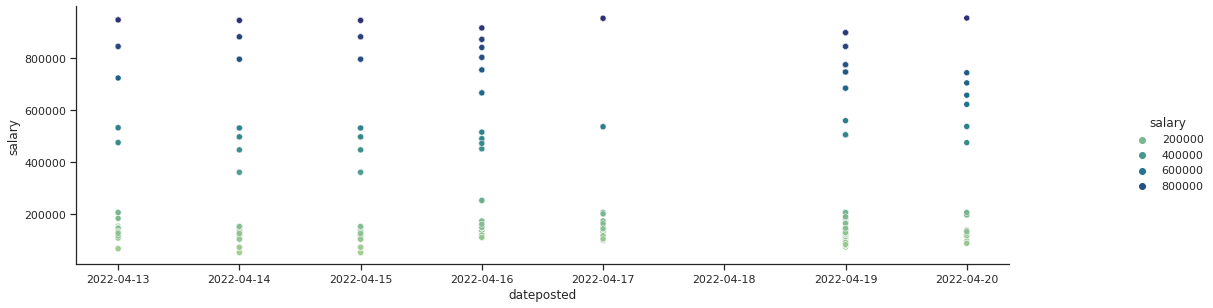

In [355]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.

In [356]:
outliers = []
def z_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(munged)

#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.

In [357]:
def iqr_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    Q1, Q3 = np.percentile(sample,[25,75])
    iqr = Q3-Q1
    lower_bound = Q1-(1.5*iqr)
    upper_bound = Q3+(1.5*iqr)
    for i in sample:
        if (i < lower_bound)  | (i > upper_bound):
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
iqr_detect(munged)

[947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 947120.0,
 945120.0,
 945120.0,
 945120.0,
 945120.0,
 945120.0,
 945120.0,
 945120.0,
 945120.0,
 953121.0,
 953121.0,
 953121.0,
 953121.0,
 954121.0]

In [358]:
def unique(list1):
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x)
        
mn = min(outliers)
mx = max(outliers)
print(f'The {len(set(outliers))} Unique Outliers Are:')
unique(outliers)
print(f'- With a minumum of ${round(mn)} and a maximum of ${round(mx)}')

The 4 Unique Outliers Are:
947120.0
953121.0
945120.0
954121.0
- With a minumum of $945120 and a maximum of $954121


In [359]:
# Take a look at those tables.

outliers = munged[munged['salary'].isin(outliers)]
munged.drop(outliers.index, axis=0,inplace=True)
outliers

,company,location,rating,job_title,text,salary,dateposted,state,city
3,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
18,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
34,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
49,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
66,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
95,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
110,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
125,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
142,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
155,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote


In [360]:
null = len(munged[munged.salary.isnull()])
nnull = len(munged[munged.salary.notnull()])

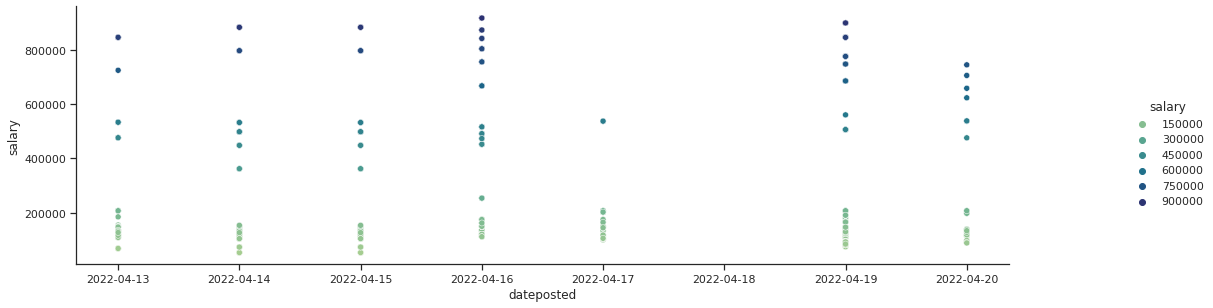

In [361]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

- Dropping 30 outliers now leaves 1180, or 79.46%, of rows with with salary information,
- The remaining 305 rows, or 20.54%, are missing salary data.


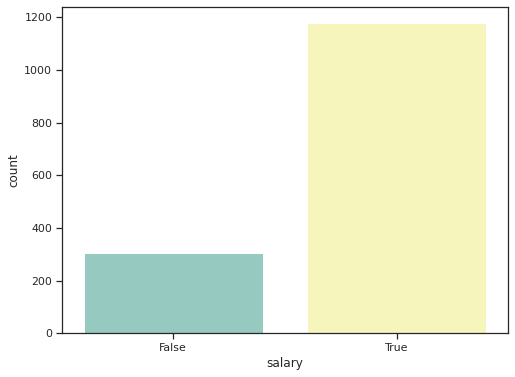

In [362]:
sns.countplot(x='salary', data=munged.notnull(), palette='Set3')
print(f'- Dropping {len(outliers)} outliers now leaves {nnull}, or {round(nnull/len(munged)*100,2)}%, of rows with with salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}%, are missing salary data.')


In [363]:
munged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1485 entries, 0 to 1514
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   company     1485 non-null   object        
 1   location    1485 non-null   object        
 2   rating      1485 non-null   float64       
 3   job_title   1485 non-null   object        
 4   text        1485 non-null   object        
 5   salary      1180 non-null   float64       
 6   dateposted  1485 non-null   datetime64[ns]
 7   state       1485 non-null   object        
 8   city        1485 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 156.0+ KB


In [364]:
munged.to_csv(f'../app/data/munged_data.csv', index=False)